<a href="https://colab.research.google.com/github/v-aap/COMP3132/blob/main/LabWeek2/LabWeek2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression as a Single Neuron Model

## Imports

In [1]:
import numpy as np
import h5py
import requests
import os
import matplotlib.pyplot as plt

## Helper Functions

In [2]:
def download_file(url, local_filename):
    """
    Downloads a file from a URL and saves it locally.
    """
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename}...")
        response = requests.get(url)
        if response.status_code == 200:
            with open(local_filename, 'wb') as f:
                f.write(response.content)
            print(f"File downloaded: {local_filename}")
        else:
            raise Exception(f"Failed to download file from {url}. Status code: {response.status_code}")
    else:
        print(f"File already exists: {local_filename}")

def load_dataset():
    # URLs of the .h5 files
    train_url = 'https://github.com/PyDataGBC/PyML2025/raw/refs/heads/main/LabWeek2/dataset/train_catvnoncat.h5'
    test_url = 'https://github.com/PyDataGBC/PyML2025/raw/refs/heads/main/LabWeek2/dataset/test_catvnoncat.h5'

    # Local file paths
    train_file = 'train_catvnoncat.h5'
    test_file = 'test_catvnoncat.h5'

    # Download the files if not already present
    download_file(train_url, train_file)
    download_file(test_url, test_file)

    # Open the files using h5py
    train_dataset = h5py.File(train_file, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # Train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # Train set labels

    test_dataset = h5py.File(test_file, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # Test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # Test set labels

    classes = np.array(test_dataset["list_classes"][:])  # List of classes

    # Reshape labels
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Importing Dataset

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

File downloaded: train_catvnoncat.h5
File downloaded: test_catvnoncat.h5


## Data Visualization

label:  [1]


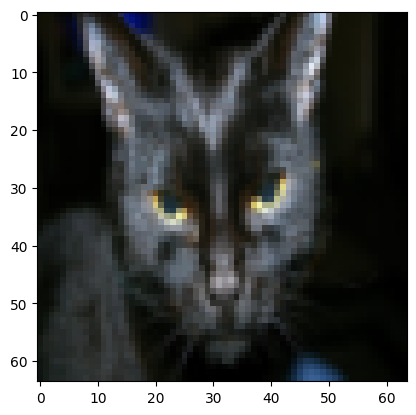

In [4]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print("label: ", train_set_y[:, index])

### **Exercise 1:** Take a look at five different images in test set. Try to see both cat and non-cat samples.

label:  [0]


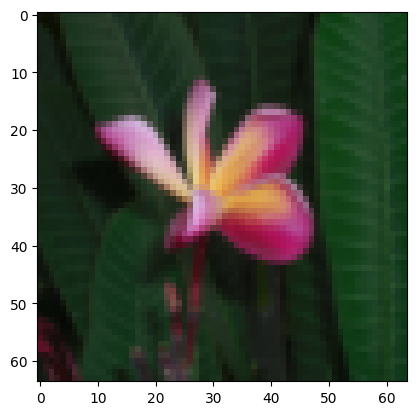

label:  [1]


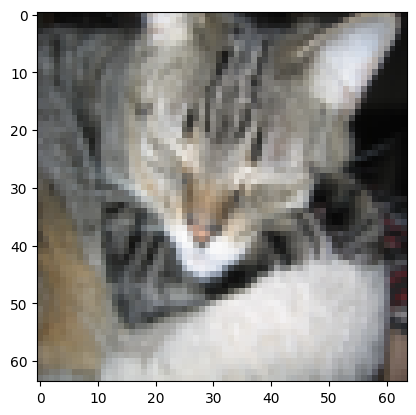

label:  [1]


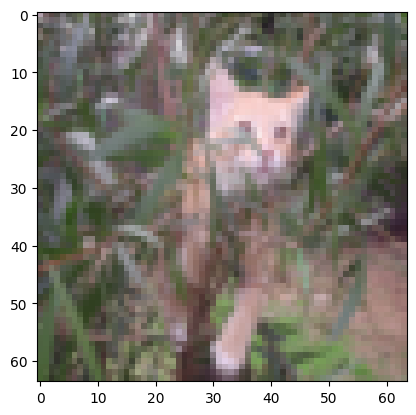

label:  [0]


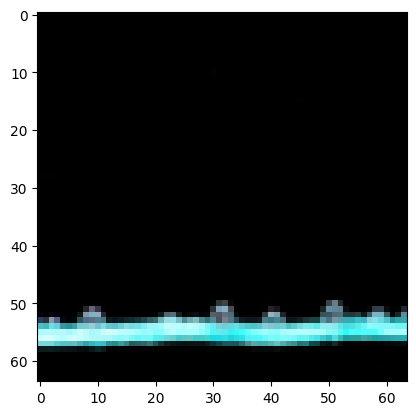

label:  [0]


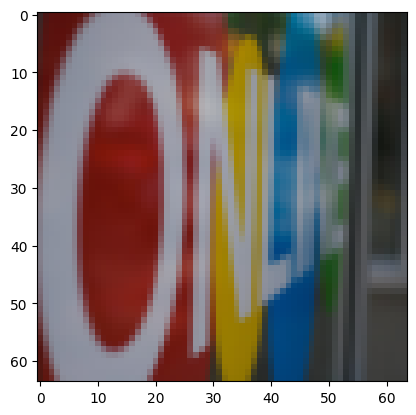

In [12]:
import random

# Get 5 unique random indices within the range of the dataset
random_indices = random.sample(range(train_set_x_orig.shape[0]), 5)

# Create a list to store labels of the 5 images
labels_of_5 = []

for index in random_indices:
    plt.imshow(train_set_x_orig[index])
    print("label: ", train_set_y[:, index])
    plt.show()
    labels_of_5.extend(train_set_y[:, index]) #add label to labels_of_5 list


### **Exercise 2:** What percentage of the pictures contain cats?

In [14]:
percentage = (labels_of_5.count(1) / len(labels_of_5)) * 100
print(f"Percentage of images containing cats within the 5 random images: {percentage:.2f}%")

Percentage of images containing cats within the 5 random images: 40.00%


## Data Preprocessing

### Numerical Representation of Images

![preprocessing](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/imvectorkiank.png)

### Simple Numerical Example

![](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/imtovec_example.webp)

In [15]:
airplane_image = np.array([[[255, 123, 135],[44, 12, 15],[56, 87, 90]],[[255, 133, 175],[24, 123, 169],[98, 66, 77]],[[66, 54, 88 ],[55, 98, 54],[87, 142, 89]]])
print(airplane_image.shape)
print(airplane_image)

(3, 3, 3)
[[[255 123 135]
  [ 44  12  15]
  [ 56  87  90]]

 [[255 133 175]
  [ 24 123 169]
  [ 98  66  77]]

 [[ 66  54  88]
  [ 55  98  54]
  [ 87 142  89]]]


In [16]:
airplane_flatten = airplane_image.flatten()
print(airplane_flatten.shape)
print(airplane_flatten)

(27,)
[255 123 135  44  12  15  56  87  90 255 133 175  24 123 169  98  66  77
  66  54  88  55  98  54  87 142  89]


### **Exercise 3:** Check the shape of the train and test datasets along with their labels. Try to interpret the numbers in the shapes.

**Notes:**
- The images are 64x64 `pixels`.
- There are 3 RGB `channels`.
- The train set contains 209 `batches` of images, and the test set contains 50 `batches` of images.

In [18]:
# Example of random datasets (replace with your actual dataset loading code)
train_images = np.random.randint(0, 256, (209, 64, 64, 3))  # 209 batches of 64x64 images with 3 RGB channels
test_images = np.random.randint(0, 256, (50, 64, 64, 3))    # 50 batches of 64x64 images with 3 RGB channels

# Check the shape of the train and test datasets
print("Train Images Shape:", train_images.shape)
print("Test Images Shape:", test_images.shape)


Train Images Shape: (209, 64, 64, 3)
Test Images Shape: (50, 64, 64, 3)


### Flattening the Train and Test Datasets

In [19]:
train_flat = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1)
print(train_flat.shape)

test_flat = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1)
print(test_flat.shape)

train_label = train_set_y[0]
print(train_label.shape)

test_label = test_set_y[0]
print(test_label.shape)



(209, 12288)
(50, 12288)
(209,)
(50,)


### Exercise 4: Why the dimension of flattened image is 12288?

The flattened image has a dimension of 12288 because each image is 64
pixels by 64 pixels, and has 3 color channels (RGB).
Therefore, the total number of pixels is 64 * 64 * 3 = 12288.  
Flattening the image converts this 3-dimensional array into a 1-dimensional
array of length 12288, where each element represents a pixel's
intensity value for a specific color channel.


## Implementing Logistic Regression

![](https://raw.githubusercontent.com/PyDataGBC/PyML2025/refs/heads/main/LabWeek2/assets/LogReg_kiank.png)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


### **Exercise 5:** Train a `LogisticRegression` classifier to run a binary classification on the flattened cat pictures.

In [24]:
# Assuming you have your dataset loaded as NumPy arrays
# X_train and X_test should be flattened image vectors
# y_train and y_test should be binary labels (0 or 1)

# Sample dataset (replace with your actual data)
# Let's assume X_train has 209 images (flattened) with 64x64x3 pixels
# and y_train has the corresponding labels (0 = not a cat, 1 = cat)
X_train = np.random.rand(209, 64*64*3)  # Replace with your actual data
y_train = np.random.randint(0, 2, 209)  # Random binary labels
X_test = np.random.rand(50, 64*64*3)    # Replace with your actual test data
y_test = np.random.randint(0, 2, 50)    # Random binary labels

# Step 1: Initialize the model
log_reg = LogisticRegression(max_iter=1000)

# Step 2: Train the model
log_reg.fit(X_train, y_train)

# Step 3: Predict on the test set
y_pred = log_reg.predict(X_test)

# Step 4: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Step 5: Print the accuracy
print("Test Accuracy:", accuracy)


Test Accuracy: 0.54


### **Exercise 6:** Evaluate your model manually

1. Choose a random index of an image.
2. Display the image.
3. Print the original label.
4. Print the predicted label.
5. Repeat this process multiple times to identify which pictures are more challenging for the model.

### **Exercise 7:** Report the overall accuracy of your classifier.

In [ ]:
#you code here

## MNIST dataset (Optional)

In [ ]:
#import mnist dataset
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

Label:  8
Image Shape:  (28, 28)


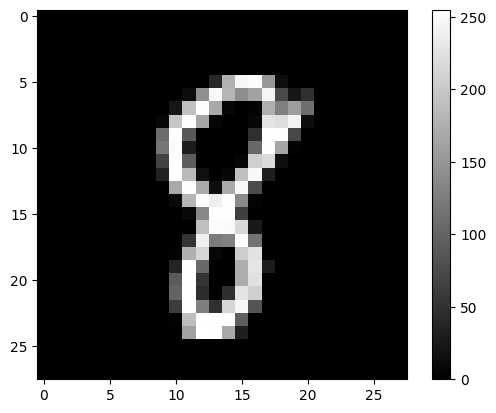

In [ ]:
#Note: Run this cell multiple times
index = np.random.randint(0, x_train.shape[0])
print("Label: ", y_train[index])
print("Image Shape: ", x_train[index].shape)
plt.imshow(x_train[index], cmap='gray')
plt.colorbar()

### **Excercise 8:** What is the difference between a black-and-white image and a color image in terms of numerical representation?

your answer here:

### **Exercise 9:** Select one data sample and flatten it. What is the size of the flattened image and why?

In [ ]:
## your code here

### **Excercise 10:** Flatten the Entire Train and Test Datasets

In [ ]:
##your code here

**Some food for thought:** What would the architecture of my model be if I used more than one neuron to predict the label?